# Tracking Exposed Special Report: Data Set Visualization


## Content Restrictions on TikTok in Russia following the Ukrainian War
## April 11, 2022

## Import the Data

In [51]:
import pandas as pd
from datetime import datetime, timedelta

In [52]:
data_path = 'data/'

# LOAD THE DATASETS

The different datasets are added in a dict:

In [53]:
dfs = {}

## SET 1: Pro-Kremlin Hashtags

In [54]:
dataframe_path = data_path + 'tk_df_pro_kremlin.pkl'
tk_df_pro_kremlin = pd.read_pickle(dataframe_path)
tk_df_pro_kremlin.shape

(13091, 14)

**Label pro war**

In [55]:
tk_df_pro_kremlin['pro_anti_war'] = 'pro_war'

**Remove duplicates**

In [56]:
tk_df_pro_kremlin.drop_duplicates('uri', inplace=True)
tk_df_pro_kremlin.shape

(5628, 15)

In [57]:
dfs['pro_kremlin'] = tk_df_pro_kremlin

## SET 2: Hand Curated Anti-war Hashtags

In [58]:
dataframe_path = data_path + 'tk_df_anti_war.pkl'
tk_df_anti_war = pd.read_pickle(dataframe_path)
tk_df_anti_war.shape

(16117, 14)

**Label pro war**

In [59]:
tk_df_anti_war['pro_anti_war'] = 'anti_war'

**Remove duplicates**

In [60]:
tk_df_anti_war.drop_duplicates('uri', inplace=True)
tk_df_anti_war.shape

(6244, 15)

In [61]:
dfs['anti_war'] = tk_df_anti_war

## Combine the datasets

In [62]:
# concatenate the dataframes from all the datasets
tk_df = pd.concat([df for df in dfs.values()])

In [63]:
# The default index corresponds to the rank (order) in the API response to the hashtag query
tk_df['order'] = tk_df.index
tk_df.reset_index(drop=True)
tk_df.shape

(11872, 16)

In [64]:
dfs['all'] = tk_df

In [65]:
tk_df.pro_anti_war.value_counts()

anti_war    6244
pro_war     5628
Name: pro_anti_war, dtype: int64

## Hashtag distribution in the loaded dataset:

In [66]:
hashtag_counts = tk_df.hashtag_query.value_counts()
seed_hashtags = list(hashtag_counts.index)
hashtag_counts

zанаших              1223
путинхуйло           1063
нетвойне             1049
нетвойнесукраиной    1033
противійни           1025
путинкраш            1020
путиннашпрезидент    1012
ЯпротивВойны          997
славаукраїні          991
путинтоп              890
zапутина              767
zароссию              716
япротиввойны           86
Name: hashtag_query, dtype: int64

## Label if channels are available in Russia

The channel_availability data was obtained through a script that tested whether each channel was available from a Russian IP address. 

In [67]:
is_russian_channel = pd.read_pickle(data_path + 'channel_availability.pkl')

In [68]:
len(is_russian_channel)

7782

In [69]:
russian_channels = list(is_russian_channel[is_russian_channel==True].index)
len(russian_channels)

4232

In [70]:
#Label if each channel is a Russian channel in the dataframes

def add_is_russian(df, channels=is_russian_channel):
    df.reset_index(inplace=True)
    df['is_russian'] = -1
    for i, row in df[df.author.isin(list(channels.index))].iterrows():
        df.at[i, 'is_russian'] = int(channels[row.author])
    return df


In [71]:
for key, df in dfs.items():
    print('adding russian label to', key)
    df = add_is_russian(df)
    print(df.is_russian.value_counts())

adding russian label to pro_kremlin
 1    4725
 0     902
-1       1
Name: is_russian, dtype: int64
adding russian label to anti_war
0    4550
1    1694
Name: is_russian, dtype: int64
adding russian label to all
 1    6419
 0    5452
-1       1
Name: is_russian, dtype: int64



## Plot content age distribution

In [72]:
analysis_end_date = datetime(2022, 4, 6, 0, 13, 8, 425257)

We add a `days_ago` column to `tk_df` correponding to the number of days ago from now the content was published

In [73]:
for df in dfs.values():
    df['days_ago'] = df.createTime.apply(lambda x: (analysis_end_date - datetime.fromtimestamp(x)).days)

We restrict the plot to the content published in the last month and a half:

In [74]:
def counts_distribution(df, age_limit=45, 
                        categories ='is_russian', 
                        ylim=None, 
                        **kwargs):
    #return tk_df.days_ago[tk_df.days_ago<age_limit].plot.hist(bins=age_limit)
    plot_df = df[df.days_ago<age_limit]
    plot_df = plot_df.groupby(['days_ago', categories]).size().unstack()
    plot_df = plot_df[::-1]
    ax = plot_df.plot(kind='bar', 
                      stacked=True,
                      xticks=[],
                      figsize = (15,8),
                      fontsize = 15,
                      ylim=ylim,
                      #legend=False,
                      #color = [(0.5,0.4,0.5), (0.75, 0.75, 0.25)],
                      **kwargs)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    x_axis = ax.axes.get_xaxis()
    x_axis.set_label_text('')
    return ax
    

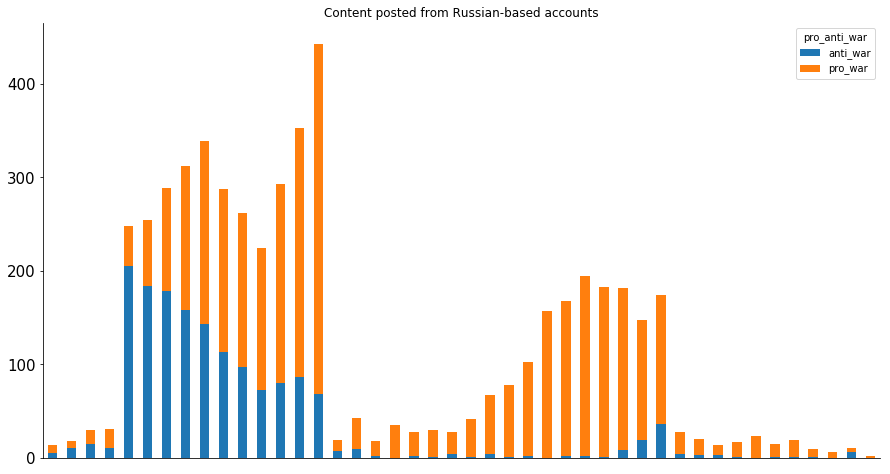

In [75]:
plot = counts_distribution(tk_df[(tk_df.is_russian==1)], categories='pro_anti_war', 
                           title='Content posted from Russian-based accounts')
plot

In [76]:
fig = plot.get_figure()
fig.savefig('anti_pro_war_tiktok.svg')